In [1]:
!pip install mediapipe opencv-python filterpy scipy matplotlib

  Using cached filterpy-1.4.5-py3-none-any.whl



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:

import cv2
import mediapipe as mp
import numpy as np
from filterpy.kalman import KalmanFilter
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt


In [3]:

def create_kalman_filter():
    kf = KalmanFilter(dim_x=4, dim_z=2)
    kf.F = np.array([[1, 0, 1, 0],
                     [0, 1, 0, 1],
                     [0, 0, 1, 0],
                     [0, 0, 0, 1]])
    kf.H = np.array([[1, 0, 0, 0],
                     [0, 1, 0, 0]])
    kf.P *= 1000
    kf.R = np.eye(2) * 5
    kf.Q = np.eye(4)
    return kf


In [4]:

def calculate_angle(a, b, c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-6)
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return np.degrees(angle)


In [5]:

def classify_joint_movement(delta_y, angle_velocity, epsilon_y=5, epsilon_theta=2):
    if delta_y < -epsilon_y and angle_velocity > epsilon_theta:
        return 'UP'
    elif delta_y > epsilon_y and angle_velocity < -epsilon_theta:
        return 'DOWN'
    elif abs(delta_y) < epsilon_y and abs(angle_velocity) < epsilon_theta:
        return 'STATIC'
    else:
        return 'TRANSITION'


In [ ]:

mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

pose_kalman_filters = {}
joint_history = {}
angle_history = {}

cap = cv2.VideoCapture(0)
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        results = pose.process(image)
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.pose_landmarks:
            for idx, lm in enumerate(results.pose_landmarks.landmark):
                key = f'joint_{idx}'
                x, y = int(lm.x * frame.shape[1]), int(lm.y * frame.shape[0])

                if key not in pose_kalman_filters:
                    pose_kalman_filters[key] = create_kalman_filter()
                    pose_kalman_filters[key].x[:2] = np.array([[x], [y]])

                kf = pose_kalman_filters[key]
                kf.predict()
                kf.update(np.array([x, y]))
                pred_x, pred_y = int(kf.x[0]), int(kf.x[1])

                if key not in joint_history:
                    joint_history[key] = []
                joint_history[key].append((pred_x, pred_y))

                cv2.circle(image, (pred_x, pred_y), 4, (0, 255, 0), -1)

            # compute angle at right elbow (12-14-16)
            try:
                r_shoulder = joint_history.get('joint_12', [])[-1]
                r_elbow = joint_history.get('joint_14', [])[-1]
                r_wrist = joint_history.get('joint_16', [])[-1]
                angle = calculate_angle(r_shoulder, r_elbow, r_wrist)
                angle_history.setdefault('right_elbow', []).append(angle)

                delta_y = r_elbow[1] - joint_history['joint_14'][-2][1]
                angle_velocity = angle - angle_history['right_elbow'][-2] if len(angle_history['right_elbow']) > 1 else 0
                label = classify_joint_movement(delta_y, angle_velocity)

                cv2.putText(image, f'Right Elbow: {label}', (30, 50), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
            except:
                pass

        cv2.imshow('Pose Tracking', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()


C:\Users\lenovo\AppData\Local\Temp\ipykernel_31008\1460882931.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_x, pred_y = int(kf.x[0]), int(kf.x[1])


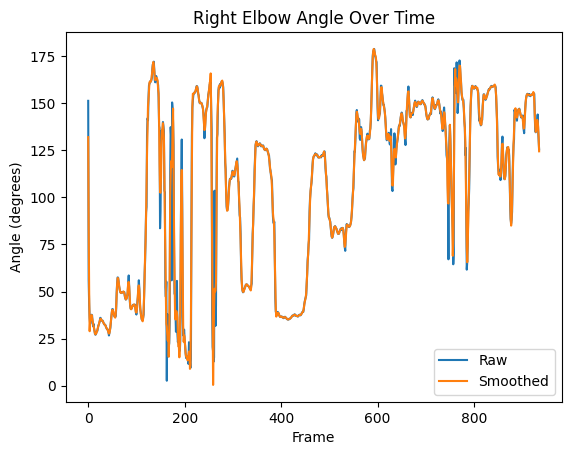

In [7]:

if 'right_elbow' in angle_history:
    raw = np.array(angle_history['right_elbow'])
    if len(raw) >= 7:
        smoothed = savgol_filter(raw, window_length=7, polyorder=2)
        plt.plot(raw, label='Raw')
        plt.plot(smoothed, label='Smoothed')
    else:
        plt.plot(raw, label='Raw')
    plt.title('Right Elbow Angle Over Time')
    plt.xlabel('Frame')
    plt.ylabel('Angle (degrees)')
    plt.legend()
    plt.show()
